# Уровень зарплат в России

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Review criterialess 
Придерживайтесь стандартного алгоритма построения прогноза:

1. Визуальный анализ ряда

2. Стабилизация дисперсии (при необходимости)

3. Выбор порядка дифференцирования

4. Выбор начальных приближений для p, q, P, Qp,q,P,Q

5. Обучение и сравнение моделей-кандидатов, выбор победителя

6. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Qp,q,P,Q.

7. Прогнозирование с помощью финальной модели.

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


            WAG_C_M
month              
1993-01-01     15.3
1993-02-01     19.1
1993-03-01     23.6
1993-04-01     30.6
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284 entries, 1993-01-01 to 2016-08-01
Data columns (total 1 columns):
WAG_C_M    284 non-null float64
dtypes: float64(1)
memory usage: 4.4 KB
None


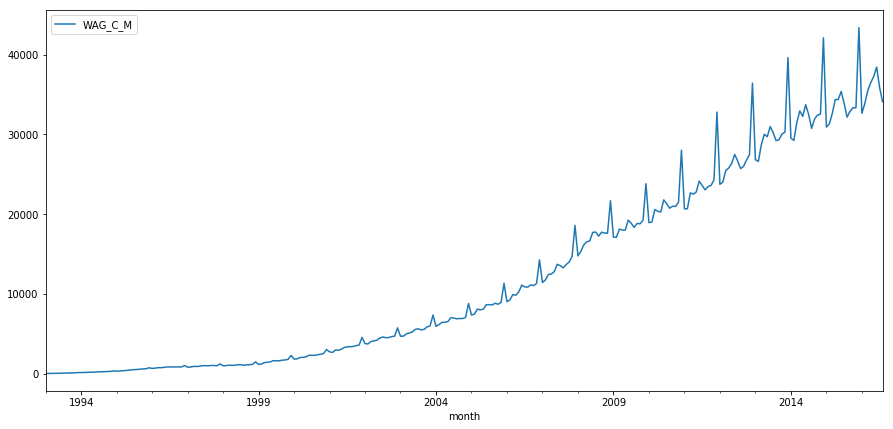

In [2]:
data2 = pd.read_csv("WAG_C_M_Updated.csv", sep=";", index_col=['month'], parse_dates=['month'], dayfirst=True)
data = pd.read_csv("WAG_C_M.csv", sep=";", index_col=['month'], parse_dates=['month'], dayfirst=True)
#Выводим первые 4 стоки
print data.head(4)
#Выводим информацию о DataFrame
print data.info()
#Печатаем график
plt.figure(figsize(15,7))
data.plot()
pylab.show()

In [3]:
data.head(4).index

DatetimeIndex(['1993-01-01', '1993-02-01', '1993-03-01', '1993-04-01'], dtype='datetime64[ns]', name=u'month', freq=None)

Веременной ряд не является страционарным. Присутствует тренд. Присутствует сезонность и дисперсия к концу графика увеличивается.
Строго проверим гипотезу о стационарности критерием Дики-Фуллера.

In [4]:
import statsmodels.api as sm
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

C:\Users\KONYAYEV.MAKSIM\AppData\Local\Continuum\anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Критерий Дики-Фуллера: p=0.991850


Гипотеза о том что ряд не стационарный не отвергается. Проведём декомпозицию ряда что бы визуально отценить его тренд и сезонность

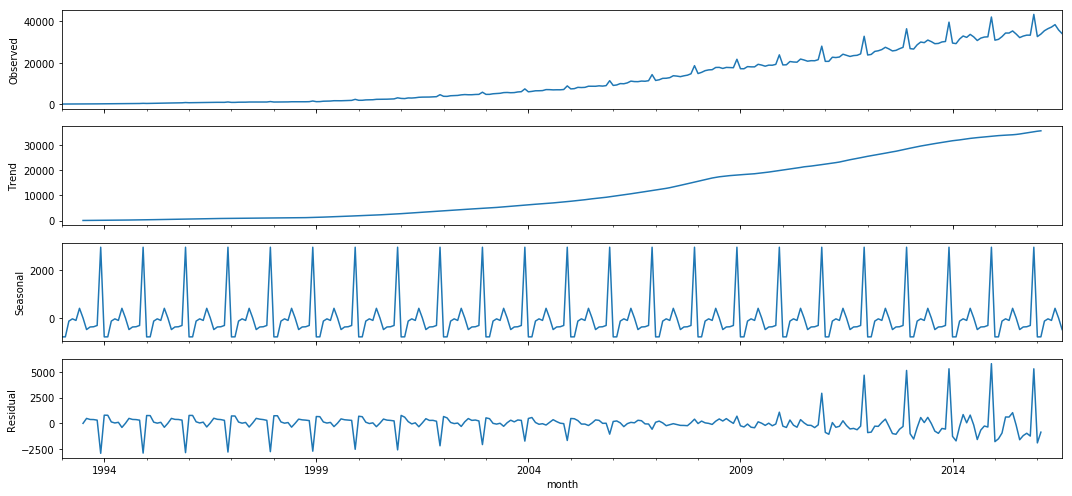

In [5]:
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
pylab.show()

Проведём преобразование Бокса-Коксона что бы нивелировать разницу в дисперисии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


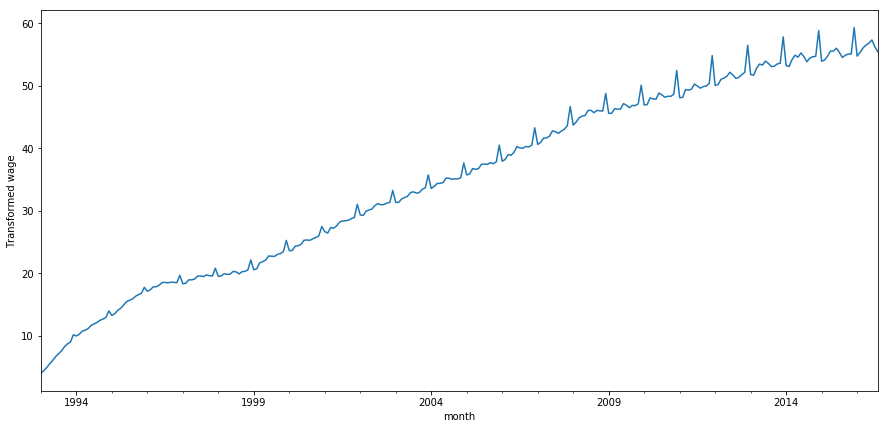

In [6]:
from scipy import stats
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.WAG_C_M_box.plot()
plt.ylabel(u'Transformed wage')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

Критерий Дики-Фуллера улучшился. Проведём сезонное дифиренцирование что бы избавиться от сезонности.

Критерий Дики-Фуллера: p=0.014697


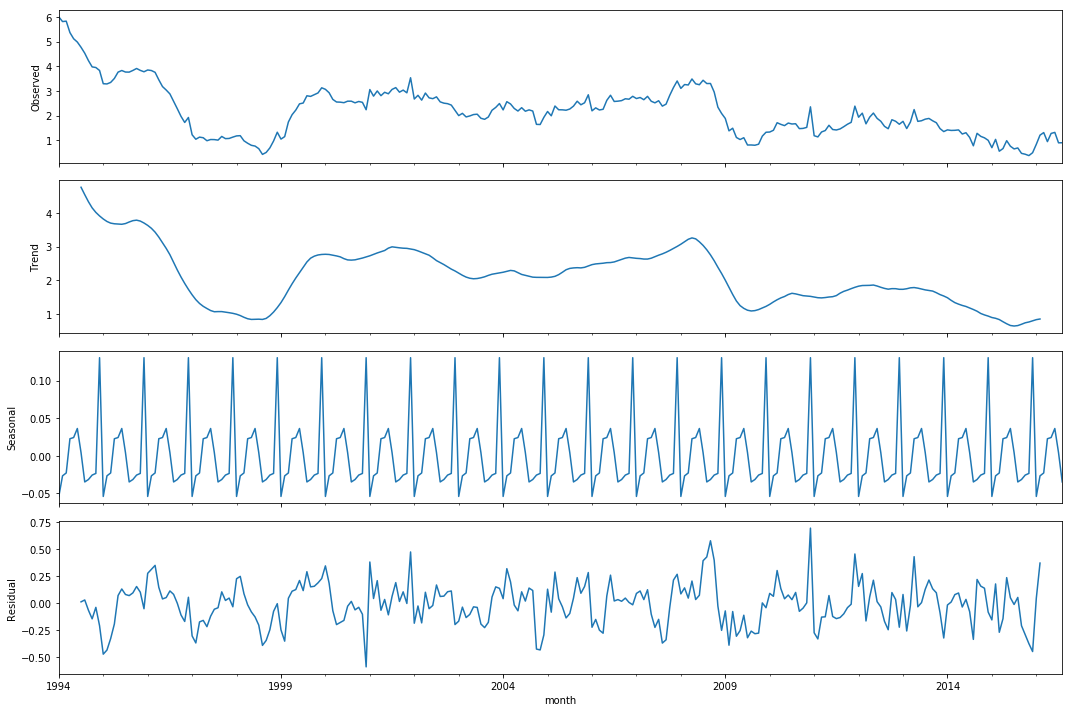

In [7]:
data['WAG_C_M_box1'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box1[12:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box1[12:])[1])

Тренд всё ещё присутствует. Поэтому проведём обычное дифференцирование. 

Критерий Дики-Фуллера: p=0.000000


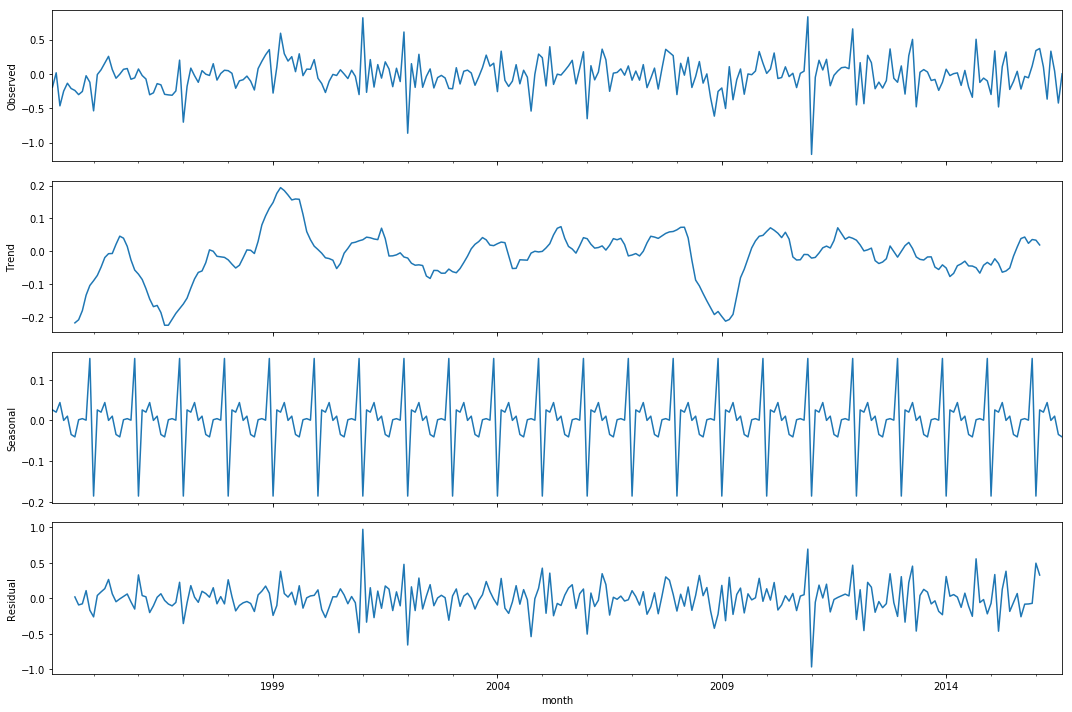

In [8]:
data['WAG_C_M_box2'] = data.WAG_C_M_box1 - data.WAG_C_M_box1.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box2[13:])[1])

Тренд колеблеца вокруг 0. Временной ряд можно признать страционарным. Критерий Дики-Фуллера отвергает гипотезу о нестационарности ряда

# Выбор мета параметров модели

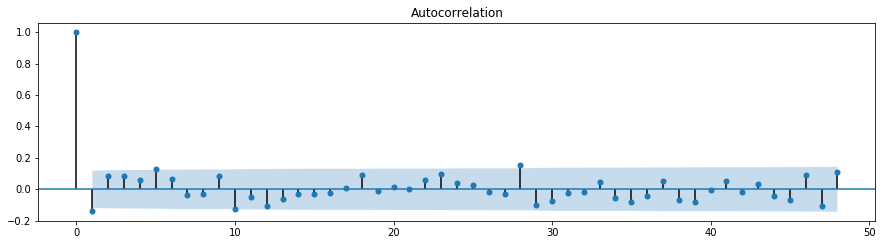

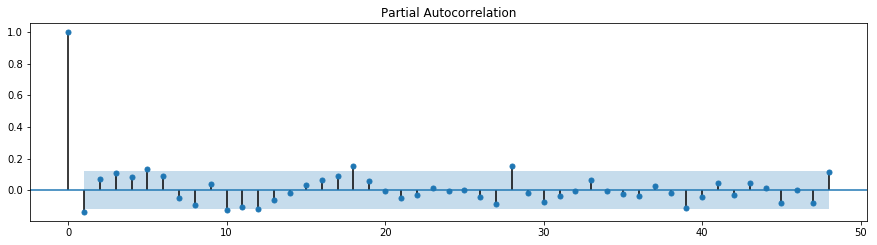

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_box2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

По автокореляционной функции выбираем начальные приближения для параметров Q, q
По частичной автокореляционной функции выбираем начальные приближения для P, p

Возьмём нач. приближение мета-параметра 

Q = 0. Нет значимых лагов кратных 12. q = 10

P = 1. Лаг на 12 значит и кратен 12. p = 10

In [19]:
ps = range(5, 10)
d=1
qs = range(5, 10)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [20]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

100

In [21]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (5, 9, 0, 0))
('wrong parameters:', (5, 9, 0, 1))
('wrong parameters:', (5, 9, 1, 0))
('wrong parameters:', (5, 9, 1, 1))
('wrong parameters:', (6, 7, 0, 0))
('wrong parameters:', (6, 7, 0, 1))
('wrong parameters:', (6, 7, 1, 0))
('wrong parameters:', (6, 7, 1, 1))
('wrong parameters:', (6, 8, 0, 0))
('wrong parameters:', (6, 8, 0, 1))
('wrong parameters:', (6, 8, 1, 0))
('wrong parameters:', (6, 8, 1, 1))
('wrong parameters:', (6, 9, 0, 0))
('wrong parameters:', (6, 9, 0, 1))
('wrong parameters:', (6, 9, 1, 0))
('wrong parameters:', (6, 9, 1, 1))
('wrong parameters:', (7, 6, 0, 0))
('wrong parameters:', (7, 6, 0, 1))
('wrong parameters:', (7, 6, 1, 0))
('wrong parameters:', (7, 6, 1, 1))
('wrong parameters:', (7, 7, 0, 0))
('wrong parameters:', (7, 7, 0, 1))
('wrong parameters:', (7, 7, 1, 0))
('wrong parameters:', (7, 7, 1, 1))
('wrong parameters:', (7, 8, 0, 0))
('wrong parameters:', (7, 8, 0, 1))
('wrong parameters:', (7, 8, 1, 0))
('wrong parameters:', (7, 8,

In [22]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
2   (5, 5, 1, 0) -25.516857
1   (5, 5, 0, 1) -25.399005
3   (5, 5, 1, 1) -24.472395
18  (6, 5, 1, 0) -24.083004
17  (6, 5, 0, 1) -23.492214


In [23]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.758
Date:                            Mon, 14 May 2018   AIC                            -25.517
Time:                                    00:29:48   BIC                             18.271
Sample:                                01-01-1993   HQIC                            -7.961
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0205      3.174     -0.006      0.995      -6.241       6.200
ar.L2          0.0098      2.077   

Критерий Стьюдента: p=0.192879
Критерий Дики-Фуллера: p=0.000000


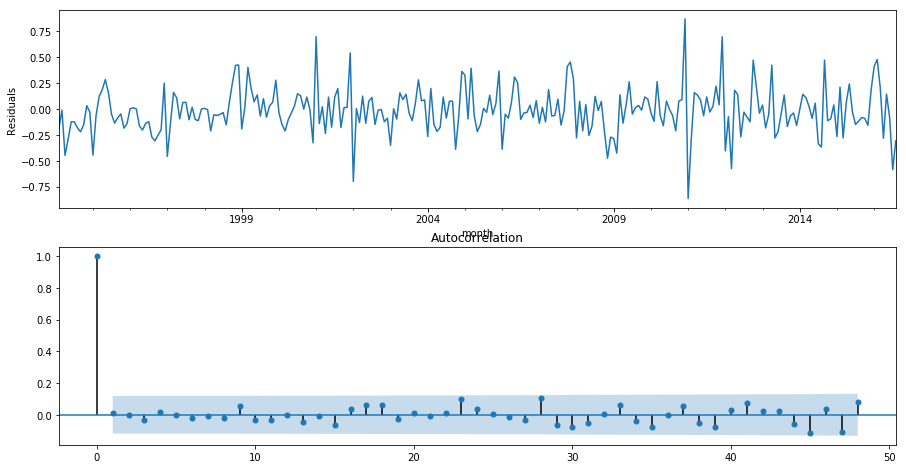

In [24]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [25]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

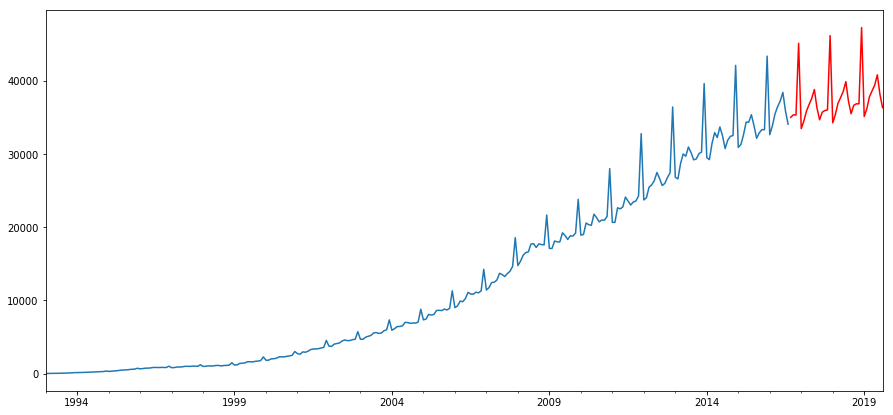

In [37]:
data3 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data3 = pd.concat([data3, future])
data3['forecast'] = invboxcox(best_model.predict(start=284, end=320), lmbda)

plt.figure(figsize(15,7))
data3.WAG_C_M.plot()
data3.forecast.plot(color='r')
pylab.show()